In [1]:
import random
import torch
import pandas as pd
import numpy as np
import json
import os
import copy
from torch import dropout, nn
from torch.optim import AdamW, Adam
from transformers import AutoModel, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import RobertaForSequenceClassification
from transformers import RobertaModel
from transformers import get_scheduler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from tqdm.auto import tqdm
import re
from nltk.tokenize import sent_tokenize


random.seed(42)
reprocess_raw =  False # whether to re-read the raw data and create combo files
# reshuffle_data = True  # whether to reprocess the document lists




data_size_reduce = .3 # multiplier for making small datasets 
                     # (only works if reshuffle_data=True)

batch_size = 8 # documents

##### HYPERPARAMETERS (moved to bottom)

# learning_rate = 5e-5 # sets AdamW optimizaiton learning rate
#                      # scales scales with each training loop if scheduler is on

# dropout_rate = 1e-1 # sets same dropout for roberta and for classification layer

# normalizer_before_class = False # toggle the normalizer before the classification layer
# use_lr_scheduler = False  # toggle the linear learning rate scheduler

# n_epochs = 8 # baseline probably minimizes after 4 Epochs'

##### end HPs

task_map = {'Quantity':1,'MeasuredProperty':2,'MeasuredEntity':3,'Qualifier':4, 'Unit':5}
num_classes = len(task_map)

model_name = 'roberta-base'
# model_name = 'allenai/biomed_roberta_base'
# model_name = 'allenai/cs_roberta_base'


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = 'cpu' # uncomment this to make debugging models easier
                 # because CPU errors are more clear

# run_name = model_name.split('/')[-1] +'_bs-'+str(batch_size)+\
#                                         '_lr-'+str(learning_rate)+\
#                                         '_drop-'+str(dropout_rate)+\
#                                         '_norm-'+str(normalizer_before_class)[0]+\
#                                         '_sched-'+str(use_lr_scheduler)[0]

# print(run_name)

In [2]:
currentdir = os.getcwd() # ~/MeasEval/baselines

combopath_txt = os.path.join(currentdir, "../data/raw/combo/text/")
combopath_annot = os.path.join(currentdir, "../data/raw/combo/tsv/")

interimpath = os.path.join(currentdir, "../data/interim/")

outputpath = os.path.join(currentdir, "../data/output/")

# runoutpath = os.path.join(outputpath,run_name+'/')

In [3]:
try: os.makedirs(runoutpath)
except: pass

In [4]:
def process_raw_txt(docs):
    processesd_txt = {}
    remove_markers = True

    cnt_toks = {"figs.": 0, "fig.": 0, "et al.": 0,
            "ref.": 0, "eq.": 0, "e.g.": 0,
            "i.e.": 0, "nos.": 0, "no.": 0,
            "spp.": 0
            }
    regex_end_checker = [".*[a-zA-Z]figs\.$", 
                        ".*[a-zA-Z]fig\.$",
                        ".*[a-zA-Z]et al\.$",
                        ".*[a-zA-Z]ref\.$",
                        ".*[a-zA-Z]eq\.$",
                        ".*[a-zA-Z]e\.g\.$",
                        ".*[a-zA-Z]i\.e\.$",
                        ".*[a-zA-Z]nos\.$",
                        ".*[a-zA-Z]no\.$",
                        ".*[a-zA-Z]spp\.$",
                        # figs., fig., et al., Ref., Eq., e.g., i.e., Nos., No., spp.
                    ]

    assert len(cnt_toks) == len(regex_end_checker)

    for docId, doc in docs.items():
        flag = False
        sentences = sent_tokenize(doc)

        fixed_sentence_tokens = []
        curr_len = 0
        for s in sentences:
            if flag == True:
                assert s[0] != ' '
                white_length = doc[curr_len:].find(s[0])

                prev_len = len(fixed_sentence_tokens[-1])
                fixed_sentence_tokens[-1] = fixed_sentence_tokens[-1] + (" "*white_length) + s

                assert fixed_sentence_tokens[-1][prev_len+white_length] == doc[curr_len+white_length], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = white_length + len(s)
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len
            else:
                if len(fixed_sentence_tokens) != 0:
                    assert s[0] != ' '
                    white_length = doc[curr_len:].find(s[0])
                    fixed_sentence_tokens.append( (" "*white_length) + s )
                else:
                    fixed_sentence_tokens.append(s)
                assert fixed_sentence_tokens[-1][0] == doc[curr_len], (fixed_sentence_tokens, doc, curr_len, tmp_this_sent_len)
                tmp_this_sent_len = len(fixed_sentence_tokens[-1])
                assert fixed_sentence_tokens[-1][-1] == doc[curr_len+tmp_this_sent_len-1], (fixed_sentence_tokens[-1], doc, curr_len, tmp_this_sent_len)
                curr_len += tmp_this_sent_len

            lower_cased_s = fixed_sentence_tokens[-1].lower()
            flag = False
            if remove_markers:
                for i, k in enumerate(cnt_toks):
                    this_regex_pattern = regex_end_checker[i]
                    if lower_cased_s.endswith(k) and re.match(this_regex_pattern, lower_cased_s) == None:
                        cnt_toks[k] += 1
                        flag = True
                        break

        processesd_txt[docId] = ''.join(fixed_sentence_tokens)
    return processesd_txt


In [5]:
def read_data(reprocess_raw = False):

    if reprocess_raw == True:
        docIds = []
        combo_txt = {}
        for fn in os.listdir(combopath_txt):
            docIds.append(fn[:-4])
            path = combopath_txt+fn
            with open(path) as textfile:
                    text = textfile.read()
                    #[:-4] strips off the .txt to get the id
                    combo_txt[fn[:-4]] = text

        combo_annot = pd.DataFrame()
        for fn in os.listdir(combopath_annot):
            path = combopath_annot+fn
            file = pd.read_csv(path,delimiter='\t',encoding='utf-8')
            combo_annot = pd.concat([combo_annot, file],ignore_index=True)

        combo_txt = process_raw_txt(combo_txt)
        assert docIds == list(combo_txt.keys()), (len(docIds), len(list(combo_txt.keys())))

        with open(interimpath+'combo_txt.json','w') as f:
            json.dump(combo_txt, f)

        combo_annot.to_csv(interimpath+'combo_annot.csv')

        return docIds, combo_txt, combo_annot
    else:
        combo_annot = pd.read_csv(interimpath+'combo_annot.csv')

        with open(interimpath+'combo_txt.json','r') as f:
            combo_txt = json.load(f)

        docIds = list(combo_txt.keys())
    
        return docIds, combo_txt, combo_annot

In [6]:
combo_docs, combo_txt, combo_annot = read_data(reprocess_raw = reprocess_raw)

In [7]:
def get_doc_list(path_txt):
    docIds = []
    for fn in os.listdir(path_txt):
        docIds.append(fn[:-4])
    return docIds

train_docs = get_doc_list(currentdir+"/../data/raw/train/text/")
dev_docs = get_doc_list(currentdir+"/../data/raw/trial/txt/")
test_docs = get_doc_list(currentdir+"/../data/raw/eval/text/")

train_docs_small = random.sample(train_docs, int(len(train_docs)*data_size_reduce))
dev_docs_small = random.sample(dev_docs, int(len(dev_docs)*data_size_reduce))
test_docs_small = random.sample(test_docs, int(len(test_docs)*data_size_reduce))

In [8]:
#### shuffle and split data

# if reshuffle_data:
#     random.seed(42)

#     random.shuffle(combo_docs)

#     percent_to_test = .1
#     percent_to_dev = .2
#     percent_to_train =  1 - percent_to_dev - percent_to_test

#     n_doc = len(combo_docs)
#     split_train = int(np.round(n_doc * percent_to_train))
#     split_dev = split_train + int(np.round(n_doc * percent_to_dev))

#     train_docs = combo_docs[:split_train]
#     dev_docs = combo_docs[split_train:split_dev]
#     test_docs = combo_docs[split_dev:]

#     train_docs = random.sample(train_docs, int(len(train_docs)*data_size_reduce))
#     dev_docs = random.sample(dev_docs, int(len(dev_docs)*data_size_reduce))
#     test_docs = random.sample(test_docs, int(len(test_docs)*data_size_reduce))

#     with open(interimpath+'train_docs.json','w') as f:
#         json.dump(train_docs, f)
#     with open(interimpath+'dev_docs.json','w') as f:
#         json.dump(dev_docs, f)
#     with open(interimpath+'test_docs.json','w') as f:
#         json.dump(test_docs, f)

# else:

#     with open(interimpath+'train_docs.json','r') as f:
#         train_docs = json.load(f)
#     with open(interimpath+'dev_docs.json','r') as f:
#         dev_docs = json.load(f)
#     with open(interimpath+'test_docs.json','r') as f:
#         test_docs = json.load(f)

In [9]:
########## Tokenizer ###########

tokenizer = AutoTokenizer.from_pretrained(model_name)

In [10]:
def process_annotation_set(annot_set):

    annot_set_processed = []

    annot_set['comboIds'] = annot_set[['docId','annotId']].agg('_'.join, axis=1)
    annot_set.set_index('comboIds',inplace=True)

    for comboId in list(annot_set.index):
        
        docId = annot_set.loc[comboId]['docId']
        annotId = annot_set.loc[comboId]['annotId']
        annotSet = annot_set.loc[comboId]['annotSet']
        annotType = annot_set.loc[comboId]['annotType']
        annotSpan = [annot_set.loc[comboId]['startOffset'],annot_set.loc[comboId]['endOffset']]

        ent_annot_processed = {
            'comboId':comboId,
            'docId':docId,
            'annotId':annotId,
            'annotSet':annotSet,
            'annotType':annotType,
            'annotSpan':annotSpan,
            'subSpanType':np.nan,
            'linkId':np.nan,
            'linkSpan':np.nan,
            'subSpan':np.nan,
            'unit':np.nan,
            'unitEncoded':np.nan,
            'misc':np.nan
        }
        
        other = annot_set.loc[comboId]['other']
        if isinstance(other,str):
            otherDict = json.loads(str(other))

            if annot_set.loc[comboId]['annotType'] != 'Quantity':

                ent_annot_processed['subSpanType'] = list(otherDict.keys())[0]
                link = list(otherDict.values())[0]

                ent_annot_processed['linkId'] = link
                linkIdx = docId+'_'+link
                linkSpan = [int(annot_set.loc[linkIdx]['startOffset']),int(annot_set.loc[linkIdx]['endOffset'])]
                ent_annot_processed['linkSpan'] = linkSpan

                spanEnds = annotSpan + linkSpan
                ent_annot_processed['subSpan'] = [min(spanEnds),max(spanEnds)]

            elif 'unit' in list(otherDict.keys()):
                unit = otherDict['unit']
                ent_annot_processed['unit'] = unit
                ent_annot_processed['unitEncoded'] = tokenizer.encode(unit)[1:-1]
            else:
                ent_annot_processed['misc'] = otherDict


        annot_set_processed.append(ent_annot_processed)
   
    return pd.DataFrame.from_dict(annot_set_processed).set_index('comboId')

combo_annot_processed = process_annotation_set(combo_annot)
combo_annot_processed.to_csv(interimpath+'combo_annot_processed.csv')
combo_annot_processed.sample(7)


,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S0032063313003218-5227_T3-1,S0032063313003218-5227,T3-1,1,MeasuredProperty,"[29, 40]",HasQuantity,T1-1,"[44, 55]","[29, 55]",NaN,NaN,NaN
S0925443913001385-1638_T5-3,S0925443913001385-1638,T5-3,3,Qualifier,"[148, 157]",Qualifies,T3-3,"[191, 196]","[148, 196]",NaN,NaN,NaN
S0012821X12004384-1610_T4-1,S0012821X12004384-1610,T4-1,1,Qualifier,"[15, 30]",Qualifies,T3-1,"[4, 14]","[4, 30]",NaN,NaN,NaN
S016412121300188X-4207_T1-2,S016412121300188X-4207,T1-2,2,Quantity,"[158, 161]",NaN,NaN,NaN,NaN,%,[207],NaN
S2213158213000582-1183_T4-1,S2213158213000582-1183,T4-1,1,MeasuredEntity,"[142, 172]",HasProperty,T2-1,"[119, 138]","[119, 172]",NaN,NaN,NaN
S0032063313003218-6078_T4-1,S0032063313003218-6078,T4-1,1,MeasuredProperty,"[96, 101]",HasQuantity,T1-1,"[117, 121]","[96, 121]",NaN,NaN,NaN
S0006322312001096-1221_T84-6,S0006322312001096-1221,T84-6,6,MeasuredEntity,"[528, 553]",HasProperty,T74-6,"[512, 520]","[512, 553]",NaN,NaN,NaN


In [11]:
# add unit annotation spans labeling by:
# 1. using row info to create dictionaries for unit span
# 2. putting dictionaries into a unit df
# 3. concatenating the unit df with combo_annot_processed df

# filter df to where units are not nan values
combo_annot_processed_units = combo_annot_processed
combo_annot_processed_units = combo_annot_processed_units[~combo_annot_processed_units['unit'].isna()] 

def get_unit_subspan_row_info(docId, annotId, annotSet, annotType, annotSpan, unit):
    """
    Input: combo_annot_processed_units columns (used as apply function across rows)
    Output: df with new column 'dict'. For each row, 'dict' contains a dictionary
    of the new row
    """

    unit_rows_dict = {}
    not_found_dict = {}

    comboId = docId + "_" + annotId
    docId = docId
    annotId = annotId
    annotSet = annotSet
    annotType = annotType
    annotSpan = annotSpan
    unit = unit
    
    # get get doc, unit and quantity text along with quantity span
    doc_text = combo_txt[docId]
    quant_span = annotSpan
    unit_txt = unit
    quant_txt = doc_text[quant_span[0]:quant_span[1]]

    # get unit span
    # 1. try to set unit start; works only if the units are found within the quantity span
    try:
        unit_start = quant_txt.index(unit_txt) + quant_span[0]
        unit_end = unit_start + len(unit_txt)

    # 2. if not, then try to find units in an expanded quantity span
    except ValueError:

        try:
            ## add margin to quant span search window (20 captures everything)
            charSearchMargin = 20
            quant_txt = doc_text[(quant_span[0]-charSearchMargin):(quant_span[1]+charSearchMargin)]

            ## subtract margin
            unit_start = quant_txt.index(unit_txt) + quant_span[0] - charSearchMargin
            unit_end = unit_start + len(unit_txt)

        # 3. if not either of those, adds the info to a dict (used for testing)
        except ValueError:
            not_found_dict[comboId] = (docId, doc_text, annotSpan, quant_txt, unit)

    # set unit row vars
    unit_comboId = docId + "_" + annotId + "u"
    unit_docId = docId
    unit_annotId = annotId + "u"
    unit_annotSet = annotSet
    unit_annotType = "Unit"
    unit_annotSpan = (unit_start, unit_end)
    unit_subSpanType = np.nan
    unit_linkId = np.nan
    unit_linkSpan = np.nan
    unit_subSpan = np.nan
    unit_unit = unit
    unit_unitEncoded = np.nan
    unit_misc = np.nan

    # make dict of unit row values
    unit_rows_dict['comboId'] = unit_comboId
    unit_rows_dict['docId'] = unit_docId
    unit_rows_dict['annotId'] = unit_annotId
    unit_rows_dict['annotSet'] = unit_annotSet
    unit_rows_dict['annotType'] = unit_annotType
    unit_rows_dict['annotSpan'] = list(unit_annotSpan)
    unit_rows_dict['subSpanType'] = unit_subSpanType
    unit_rows_dict['linkId'] = unit_linkId
    unit_rows_dict['linkSpan'] = unit_linkSpan
    unit_rows_dict['subSpan'] = unit_subSpan
    unit_rows_dict['unit'] = unit_unit
    unit_rows_dict['unitEncoded'] = unit_unitEncoded
    unit_rows_dict['misc'] = unit_misc

    # print info for those that were not found
    if len(not_found_dict) == 0:
        pass
    else:
        print(not_found_dict)

    return unit_rows_dict


combo_annot_processed_units['dict'] = combo_annot_processed_units.apply(lambda row: get_unit_subspan_row_info(
                                                                                row['docId'],
                                                                                row['annotId'],
                                                                                row['annotSet'],
                                                                                row['annotType'],
                                                                                row['annotSpan'],
                                                                                row['unit']
                                                                                ), axis=1)


# generate dataframe containing units annotation span info 
units_df = pd.DataFrame.from_dict(list(combo_annot_processed_units['dict'].values)).set_index('comboId')

# add the units df above to combo_annot_processed (total 6151 rows = 4853 rows from original combo_annot_processed and 1298 rows from units_df)
combo_annot_processed = pd.concat([combo_annot_processed, units_df])
combo_annot_processed

/tmp/ipykernel_8693/2386584782.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combo_annot_processed_units['dict'] = combo_annot_processed_units.apply(lambda row: get_unit_subspan_row_info(


,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S0006322312001096-1136_T1-1,S0006322312001096-1136,T1-1,1,Quantity,"[73, 77]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0006322312001096-1136_T2-1,S0006322312001096-1136,T2-1,1,MeasuredEntity,"[49, 69]",HasQuantity,T1-1,"[73, 77]","[49, 77]",NaN,NaN,NaN
S0006322312001096-1136_T1-2,S0006322312001096-1136,T1-2,2,Quantity,"[103, 123]",NaN,NaN,NaN,NaN,NaN,NaN,{'mods': ['IsList']}
S0006322312001096-1136_T2-2,S0006322312001096-1136,T2-2,2,MeasuredEntity,"[79, 99]",HasQuantity,T1-2,"[103, 123]","[79, 123]",NaN,NaN,NaN
S0006322312001096-1136_T1-3,S0006322312001096-1136,T1-3,3,Quantity,"[205, 222]",NaN,NaN,NaN,NaN,participants,"[42038, 3277]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
S2213671113001306-908_T1-2u,S2213671113001306-908,T1-2u,2,Unit,"[82, 84]",NaN,NaN,NaN,NaN,μm,NaN,NaN
S2213671113001306-910_T1-1u,S2213671113001306-910,T1-1u,1,Unit,"[907, 908]",NaN,NaN,NaN,NaN,×,NaN,NaN
S2213671113001306-910_T1-2u,S2213671113001306-910,T1-2u,2,Unit,"[980, 981]",NaN,NaN,NaN,NaN,×,NaN,NaN


In [12]:
def tokenize_and_align_labels(
                                doc_list=combo_docs,
                                txt=combo_txt,
                                processed_annotation=combo_annot_processed,
                                tokenizer=tokenizer,
                                taskLabelMap=task_map
                            ):

    toks_with_labels = []
    special_ids = tokenizer.all_special_ids
    collisionDict = {}

    for doc in doc_list:
        within_doc_collision_count = 0
        # print(doc)
        # print(processed_annotation.loc[processed_annotation['docId'] == doc])
        doc_annot = processed_annotation.loc[processed_annotation['docId'] == doc]
        doc_annot.set_index('annotId',inplace=True)
        # print(doc_annot)

        encoded_txt = tokenizer(txt[doc], padding='max_length', max_length=512, truncation=True)
        encoded_tokens = encoded_txt['input_ids']
        # print(encoded_tokens)

        ############### Label Primary Spans ###############

        labelIds = np.full(len(encoded_tokens),-1)
        taskCharMap = {} # Map of labels to be written within current doc
        annotSet_writeMap = {} # Map of annotSet which last wrote any position index
        taskCharList = []
        collision = False

        if len(doc_annot) > 0:
            # iterate through each annotSet (necessary to allow for rollback on collision)
            for annot_idx in range(int(doc_annot['annotSet'].max())):
                curr_annotSet = annot_idx + 1
                # print(annot_idx)
                if collision:
                    taskCharMap = taskCharMap_Backup
                    annotSet_writeMap = annotSet_writeMap_Backup
                taskCharMap_Backup = copy.deepcopy(taskCharMap)
                annotSet_writeMap_Backup = copy.deepcopy(annotSet_writeMap)
                # roll back (planned) labels if collision occurred on prior AnnotSet
                collision = False
                spans = list(doc_annot.loc[doc_annot['annotSet']==curr_annotSet]['annotSpan'])
                # get the tasks (annotTypes) which match with each span
                annotset_tasks = list(doc_annot.loc[doc_annot['annotSet']==curr_annotSet]['annotType'])
                for i in range(len(spans)):
                    span = list(range(spans[i][0],spans[i][-1]))
                    annotset_task = annotset_tasks[i]
                    # print(span)
                    # print(annotset_task)
                    if annotset_task in taskLabelMap.keys():
                        for spanCharIdx in span:
                            if spanCharIdx in taskCharMap:
                                if taskCharMap[spanCharIdx] != taskLabelMap[annotset_task]:
                                    # if we are still on the same annotSet
                                    cond_1 = annotSet_writeMap[spanCharIdx] == curr_annotSet
                                    # and we are attempting to write a 5 on top of a 1
                                    # (i.e. write a Unit onto a Quantity)
                                    cond_2 = taskLabelMap[annotset_task] == 5
                                    cond_3 = taskCharMap[spanCharIdx] == 1
                                    # error checking for unit rewriting qty
                                    # within subsequent annotSets
                                    # if cond_2 and cond_3:
                                    #     print("AnnotSet Matches:",cond_1)
                                    if cond_1 and cond_2 and cond_3:
                                        # allow the rewrite and do not flag collision
                                        pass
                                    else:
                                        # print("="*45)
                                        # print("Collision detected in doc",doc)
                                        # print("Previous mapped task:",taskCharMap[spanCharIdx],"new mapped task:",taskLabelMap[annotset_task])
                                        # print("Current span:",span)
                                        # print("Second (offending) annotSet will not be included.")
                                        # print("="*45)
                                        collisionDict[doc + '_' + 
                                                      str(within_doc_collision_count 
                                                          + 1)] = span
                                        collision = True
                                        within_doc_collision_count += 1
                                        break
                                # print(spanCharIdx)
                            taskCharMap[spanCharIdx] = taskLabelMap[annotset_task]
                            annotSet_writeMap[spanCharIdx] = curr_annotSet
                        if collision:
                            continue
                    else:
                        continue
    
                        # print(taskCharMap)
                            # taskAnnotIdCharMap[spanCharIdx] = annotId
            

        decoded = [''] * len(encoded_tokens)
        for tokenIdx, token in enumerate(encoded_tokens):
            
            if token not in special_ids:
                tokenCharStart = encoded_txt.token_to_chars(tokenIdx).start
                if tokenCharStart in list(taskCharMap.keys()):
                    labelIds[tokenIdx] = taskCharMap[tokenCharStart]
                    decoded[tokenIdx] = tokenizer.decode(token)
                else:
                    labelIds[tokenIdx] = 0
            else:
                labelIds[tokenIdx] = 0
        

        ############### Sub Spans Token Insertion and labeling ###############

        encoded_txt['doc_or_sent_id'] = doc
        encoded_txt['labels'] = labelIds
        
        toks_with_labels.append(encoded_txt)
        
    print("Total collisions avoided:", len(collisionDict))
    
    # return toks_with_labels
    return pd.DataFrame.from_dict(toks_with_labels), collisionDict

In [13]:
# stage1_train_ds, train_collisions = tokenize_and_align_labels(
#     doc_list=train_docs,
#     txt=combo_txt,
#     processed_annotation=combo_annot_processed,
#     tokenizer=tokenizer,
#     taskLabelMap=task_map)

# stage1_train_ds[stage1_train_ds['doc_or_sent_id']=='S0019103513005058-3154']

In [14]:
################# TOKENIZE #################

stage1_train_ds, train_collisions = tokenize_and_align_labels(
    doc_list=train_docs_small,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_train_ds.to_csv(interimpath+'stage1_train_ds.csv')
stage1_n_train = stage1_train_ds.shape[0]


stage1_dev_ds, dev_collisions = tokenize_and_align_labels(
    doc_list=dev_docs_small,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_dev_ds.to_csv(interimpath+'stage1_dev_ds.csv')
stage1_n_dev = stage1_dev_ds.shape[0]

stage1_test_ds, test_collisions = tokenize_and_align_labels(
    doc_list=test_docs,
    txt=combo_txt,
    processed_annotation=combo_annot_processed,
    tokenizer=tokenizer,
    taskLabelMap=task_map)
# stage1_test_ds.to_csv(interimpath+'stage1_test_ds.csv')
stage1_n_test = stage1_test_ds.shape[0]


Total collisions avoided: 28
Total collisions avoided: 17
Total collisions avoided: 92


In [15]:
def get_distribution(dataset):
    """
    Function to visualize label distribution for datasets

    Input: train/test/dev dataframe with column 'labels'
    Output: prints graph of proportion of labels and returns dict
    with label as key and proportion as value
    """

    # turn label array into counts array
    def indiv_label_distribution(array_labels):
        array_labels = array_labels
        (unique, counts) = np.unique(array_labels, return_counts=True)
        freq = np.asarray((unique, counts)).T
        return freq

    dataset = dataset
    label_column = dataset['labels']
    distr_dict = {}
    dataset['distr_arr'] = label_column.apply(indiv_label_distribution)

    # add counts from counts array into dictionary
    def add_counts(array_counts):
        array_counts = array_counts   
        for row in array_counts:
            if row[0] in distr_dict.keys():
                distr_dict[row[0]] += row[1]
            else:
                distr_dict[row[0]] = row[1]

    dataset['distr_arr'].apply(add_counts)

    # remove 0 label and its counts
    del distr_dict[0]

    # plot
    distr_dict_pct = {k: v / total for total in (sum(distr_dict.values()),) for k, v in distr_dict.items()}
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    lists = sorted(distr_dict_pct.items())
    x, y = zip(*lists)
    plt.bar(x, y)
    plt.title("label distribution")
    plt.xlabel("label")
    plt.ylabel("proportion of all labels")
    plt.show()

    print("label counts:\n", distr_dict, "\n")
    print("label proportions:")
    return distr_dict_pct



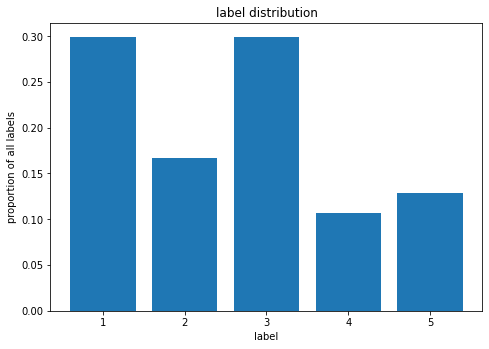

label counts:
 {1: 687, 2: 383, 3: 689, 4: 245, 5: 296} 

label proportions:


{1: 0.29869565217391303,
 2: 0.16652173913043478,
 3: 0.2995652173913044,
 4: 0.10652173913043478,
 5: 0.12869565217391304}

In [16]:
# check out distribution of training set labels
get_distribution(stage1_train_ds)

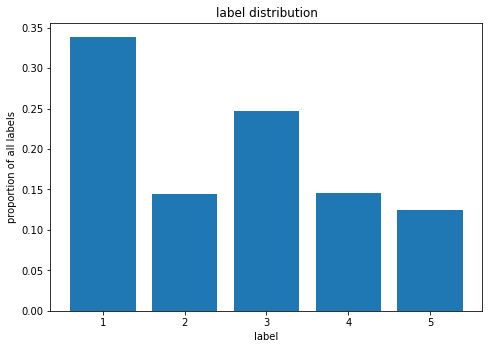

label counts:
 {1: 261, 2: 111, 3: 190, 4: 112, 5: 96} 

label proportions:


{1: 0.33896103896103896,
 2: 0.14415584415584415,
 3: 0.24675324675324675,
 4: 0.14545454545454545,
 5: 0.12467532467532468}

In [17]:
# check out distribution of dev set labels
get_distribution(stage1_dev_ds)

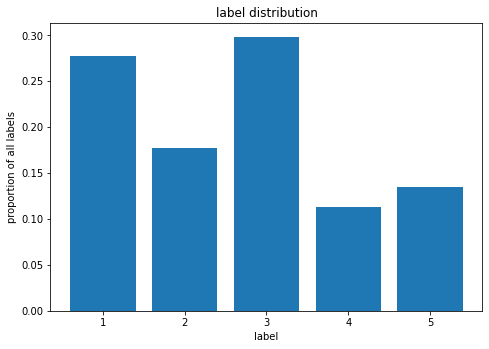

label counts:
 {1: 1119, 3: 1206, 4: 457, 5: 543, 2: 715} 

label proportions:


{1: 0.276980198019802,
 3: 0.2985148514851485,
 4: 0.11311881188118812,
 5: 0.13440594059405941,
 2: 0.17698019801980197}

In [18]:
# check out distribution of test set labels
get_distribution(stage1_test_ds)

In [19]:
### Matt
# def shorten_txt_encoding(txt, shorten_by : int):       
#     pass...

# generate a list of docIds that have token collision after shortening

# toks = list(stage1_dev_ds.sample(1)['input_ids'])

# print(toks[0])

# tokenizer.decode(toks[0])

In [20]:
def batchify(tokenized_dataset, batch_size, device):
    num_examples = int(tokenized_dataset.shape[0] / batch_size)
    batch_sizes = [batch_size for x in range(num_examples)]
    last_batch_size = tokenized_dataset.shape[0] % batch_size
    if last_batch_size:
        batch_sizes.append(last_batch_size)
    # print(batch_sizes)

    batched_dataset = []

    idf_to_torch = lambda df : torch.tensor(np.array([list(map(int,r)) for r in df])).to(device)

    for idx, size in enumerate(batch_sizes):
        start = sum(batch_sizes[:idx])
        end = sum(batch_sizes[:idx]) + size - 1
        # print(start,end,idx)
        input_ids = idf_to_torch(tokenized_dataset['input_ids'].loc[start:end])
        attention_mask = idf_to_torch(tokenized_dataset['attention_mask'].loc[start:end])
        labels = idf_to_torch(tokenized_dataset['labels'].loc[start:end])
        doc_or_sent_id = list(tokenized_dataset['doc_or_sent_id'].loc[start:end])
        
        batch = {
            'input_ids':input_ids,
            'labels':labels,
            'attention_mask':attention_mask,
            'doc_or_sent_id':doc_or_sent_id

        }
        
        batched_dataset.append(batch)

    return batched_dataset

In [21]:
################# batchify ####################

batched_train_ds = batchify(stage1_train_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)
batched_dev_ds = batchify(stage1_dev_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)
batched_test_ds = batchify(stage1_test_ds[['attention_mask','input_ids','labels','doc_or_sent_id']], batch_size, device)


In [22]:
batched_train_ds[0]

{'input_ids': tensor([[    0,   846,  1043,  ...,     1,     1,     1],
         [    0,   133,  7658,  ...,     1,     1,     1],
         [    0, 42200,     6,  ...,     1,     1,     1],
         ...,
         [    0,   104, 15513,  ...,     1,     1,     1],
         [    0,  3972,  4126,  ...,     1,     1,     1],
         [    0,   725,    12,  ...,     1,     1,     1]], device='cuda:0'),
 'labels': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 3, 3,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'doc_or_sent_id': ['S0927024813002420-1202',
  'S0016236113008041-3012',
  'S00063223

In [23]:
demo_batch = 2

demo_batch = batched_train_ds[demo_batch]


demo_doc = demo_batch['doc_or_sent_id'][0]
demo_ids = demo_batch['input_ids'].cpu().numpy()[0]
demo_tokens = tokenizer.decode(demo_batch['input_ids'].cpu().numpy()[0])
demo_labels = demo_batch['labels'].cpu().numpy()[0]
demo_mask = demo_batch['attention_mask'].cpu().numpy()[0]
latch_print = False
labeled_tokens = ''
for id, lab in zip(demo_ids, demo_labels):
    if lab:
        labeled_tokens = labeled_tokens + tokenizer.decode(id) + ' '

print(task_map)


{'Quantity': 1, 'MeasuredProperty': 2, 'MeasuredEntity': 3, 'Qualifier': 4, 'Unit': 5}


In [24]:
demo_doc

'S0167610513001001-1751'

In [25]:
print(demo_ids)

[    0 44105     4   290   924     5  1266  2249   227  2508  9706  9550
    30     5 13431   271     8 34753    41   991 12687   136    41   991
 12687  2508  2078     4    20   414    21  6408    88 23994     9   112
   475   579 47677   134     4    20  5849  5692   311     5  2526  5849
     9     5   414    11   349  6870     4    20  1266  2249   227     5
    80  9571  1189  5342  5891     6    19     5 13431   271 39694 35098
     5  2508  2078    30   227   321     8   321     4   245   475   579
 47677   134     4   497  2508  9706  2388    87   291   475   579 47677
   134     5 13431   271  2092     7    28 39694 35098     5  2508  2078
     4  7029 15864    74    28  1552     7  3094   549    42    16    41
  6030 12456     9     5   819     9    42  5448    23   182   239  2508
  9706     4     2     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1   

In [26]:
print(demo_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 1 5
 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 3 0 0 0 0 0 0 0 0 0 0 0 3
 2 0 1 1 1 1 1 1 5 5 5 5 0 0 3 2 1 1 1 5 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [27]:
print(demo_tokens)

<s>Fig. 8 shows the mean difference between wind speeds measured by the lidar and sonic anemometer against anemometer wind speed. The data was divided into bins of 1 m s−1. The error bars show the standard error of the data in each bin. The mean difference between the two instruments remains fairly constant, with the lidar overestimating the wind speed by between 0 and 0.5 m s−1. At wind speeds greater than 20 m s−1 the lidar appears to be overestimating the wind speed. Further observations would be required to determine whether this is an accurate reflection of the performance of this method at very high wind speeds.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [28]:
combo_annot_processed

,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S0006322312001096-1136_T1-1,S0006322312001096-1136,T1-1,1,Quantity,"[73, 77]",NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0006322312001096-1136_T2-1,S0006322312001096-1136,T2-1,1,MeasuredEntity,"[49, 69]",HasQuantity,T1-1,"[73, 77]","[49, 77]",NaN,NaN,NaN
S0006322312001096-1136_T1-2,S0006322312001096-1136,T1-2,2,Quantity,"[103, 123]",NaN,NaN,NaN,NaN,NaN,NaN,{'mods': ['IsList']}
S0006322312001096-1136_T2-2,S0006322312001096-1136,T2-2,2,MeasuredEntity,"[79, 99]",HasQuantity,T1-2,"[103, 123]","[79, 123]",NaN,NaN,NaN
S0006322312001096-1136_T1-3,S0006322312001096-1136,T1-3,3,Quantity,"[205, 222]",NaN,NaN,NaN,NaN,participants,"[42038, 3277]",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
S2213671113001306-908_T1-2u,S2213671113001306-908,T1-2u,2,Unit,"[82, 84]",NaN,NaN,NaN,NaN,μm,NaN,NaN
S2213671113001306-910_T1-1u,S2213671113001306-910,T1-1u,1,Unit,"[907, 908]",NaN,NaN,NaN,NaN,×,NaN,NaN
S2213671113001306-910_T1-2u,S2213671113001306-910,T1-2u,2,Unit,"[980, 981]",NaN,NaN,NaN,NaN,×,NaN,NaN


In [29]:
demo_doc

'S0167610513001001-1751'

In [30]:
combo_annot_processed.loc[combo_annot_processed['docId']==demo_doc]

,docId,annotId,annotSet,annotType,annotSpan,subSpanType,linkId,linkSpan,subSpan,unit,unitEncoded,misc
comboId,,,,,,,,,,,,
S0167610513001001-1751_T1-1,S0167610513001001-1751,T1-1,1,Quantity,"[161, 168]",NaN,NaN,NaN,NaN,m s−1,"[119, 579, 47677, 134]",NaN
S0167610513001001-1751_T3-1,S0167610513001001-1751,T3-1,1,MeasuredEntity,"[153, 157]",HasQuantity,T1-1,"[161, 168]","[153, 168]",NaN,NaN,NaN
S0167610513001001-1751_T1-2,S0167610513001001-1751,T1-2,2,Quantity,"[266, 269]",NaN,NaN,NaN,NaN,NaN,NaN,{'mods': ['IsCount']}
S0167610513001001-1751_T2-2,S0167610513001001-1751,T2-2,2,MeasuredEntity,"[270, 281]",HasQuantity,T1-2,"[266, 269]","[266, 281]",NaN,NaN,NaN
S0167610513001001-1751_T1-3,S0167610513001001-1751,T1-3,3,Quantity,"[355, 378]",NaN,NaN,NaN,NaN,m s−1,"[119, 579, 47677, 134]",NaN
S0167610513001001-1751_T4-3,S0167610513001001-1751,T4-3,3,MeasuredProperty,"[346, 351]",HasQuantity,T1-3,"[355, 378]","[346, 378]",NaN,NaN,NaN
S0167610513001001-1751_T3-3,S0167610513001001-1751,T3-3,3,MeasuredEntity,"[341, 345]",HasProperty,T4-3,"[346, 351]","[341, 351]",NaN,NaN,NaN
S0167610513001001-1751_T1-4,S0167610513001001-1751,T1-4,4,Quantity,"[395, 416]",NaN,NaN,NaN,NaN,m s−1,"[119, 579, 47677, 134]",NaN
S0167610513001001-1751_T4-4,S0167610513001001-1751,T4-4,4,MeasuredProperty,"[388, 394]",HasQuantity,T1-4,"[395, 416]","[388, 416]",NaN,NaN,NaN


In [31]:
print(labeled_tokens)

 bins  1  m  s − 1  two  instruments  wind  speed  between  0  and  0 . 5  m  s − 1  wind  speeds  greater  than  20  m  s − 1 


In [32]:
#### Stage 2 Stuff (not currently used)

# special_token_map = dict(zip(tokenizer.all_special_tokens,tokenizer.all_special_ids))

# demo_annots = combo_annot_processed.loc[combo_annot['docId']==demo_doc]

# demo_txt = combo_txt[demo_doc]

# encoded_demo_txt = tokenizer(demo_txt, padding='max_length', max_length=512, truncation=True)
# demo_token_startchar = []
# for idx, id in enumerate(encoded_demo_txt['input_ids']):
#     try: tokenCharStart = encoded_demo_txt.token_to_chars(idx).start
#     except: tokenCharStart = np.nan
#     demo_token_startchar.append(tokenCharStart)

# subSpan_ds = {}
# for comboId, annot in demo_annots.iterrows():
#     if isinstance(annot['subSpanType'],float): continue # nans are floats
#     print(comboId)
#     print(annot['annotType'])
#     print(annot['subSpanType'])
#     print(annot['subSpan'][0],annot['subSpan'][1])
#     subSpanRange = list(range(annot['subSpan'][0],annot['subSpan'][1]))
#     # print(subSpanRange)
#     subSpanIds = []
#     subSpanLabels = []
#     for id, label, startChar in zip(demo_ids, demo_labels, demo_token_startchar):
#         if startChar in subSpanRange:
#             subSpanIds.append(id)
#             subSpanLabels.append(label)
#     print(subSpanIds)
#     print(subSpanLabels)
#     print(tokenizer.decode(subSpanIds,skip_special_tokens=True))
#     print()



In [33]:
def build_model(dropout_rate, normalizer_before_class):

    class Stage1model(nn.Module):
        def __init__(self, dropout=dropout_rate):
            super(Stage1model, self).__init__()
            self.mod = RobertaModel.from_pretrained(
                        model_name,
                        num_labels=num_classes+1,
                        hidden_dropout_prob=dropout,
                        output_hidden_states=True)
            if normalizer_before_class: 
                self.norm = nn.BatchNorm1d(512, eps=self.mod.config.layer_norm_eps)
            self.drop = nn.Dropout(self.mod.config.hidden_dropout_prob)
            self.classifier = nn.Linear(self.mod.config.hidden_size, num_classes+1)

        def forward(self, input_ids, attention_mask):
            output = self.mod(input_ids=input_ids,attention_mask=attention_mask)
            y_hat = output.hidden_states[-1]
            if normalizer_before_class: y_hat = self.norm(y_hat)
            y_hat = self.drop(y_hat)
            y_hat = self.classifier(y_hat).permute(0,2,1)
            return y_hat

    model = Stage1model().to(device)

    return model



In [34]:
# criterion = torch.nn.CrossEntropyLoss(reduction='sum')
# optimizer = AdamW(model.parameters(), lr=learning_rate)

# n_training_steps = n_epochs * len(batched_train_ds)

# if use_lr_scheduler:
#     n_training_steps = n_epochs * len(batched_train_ds)
#     lr_scheduler = get_scheduler(
#         name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=n_training_steps
#     )


def train_epoch(ds, criterion):

    model.train()

    ypred = []
    ytrue = []
    loss_log = []
    for idx, batch in enumerate(ds):

        labels = batch['labels']
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        
        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)
        
        loss = criterion(logits, labels)
        loss_log.append(loss.item())
        
        loss.backward()
        optimizer.step()
        if use_lr_scheduler: lr_scheduler.step()

        progress_bar.update(1)
            
    return loss_log



def eval_epoch(ds, criterion):

    model.eval()

    ypred = []
    ytrue = []
    loss_log = []
    with torch.no_grad():
        for idx, batch in enumerate(ds):

            labels = batch['labels']
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            logits = model(input_ids, attention_mask)
            
            loss = criterion(logits, labels)
            loss_log.append(loss.item())

            for dlogits, dlabels in zip(logits.permute(0,2,1), labels):
                    for tlogits, tlabels in zip(dlogits, dlabels):
                        ypred.append(tlogits.argmax().item())
                        ytrue.append(tlabels.item())

            progress_bar.update(1)

    acc = metrics.accuracy_score(ytrue,ypred)
    report = classification_report(ytrue,ypred,
                                    labels=list(task_map.values()),
                                    target_names=list(task_map.keys()),
                                    output_dict=True,
                                    zero_division=0)

                                    

    return loss_log, acc, report, ytrue, ypred

In [35]:
def train_dev_loop(n_epochs):

    run_report = {  'epoch':[],
                    'train_loss':[],
                    'eval_train_loss':[],
                    'eval_train_acc':[],
                    'eval_train_ytrue':[],
                    'eval_train_ypred':[],
                    'eval_train_rpt':[],
                    'eval_dev_loss':[],
                    'eval_dev_acc':[],
                    'eval_dev_ytrue':[],
                    'eval_dev_ypred':[],
                    'eval_dev_rpt':[],
                }

    # num_total_steps = n_epochs * (len(batched_train_ds) * 2 + len(batched_dev_ds))
    # progress_bar = tqdm(range(num_total_steps))

    for epoch in range(n_epochs):
        run_report['epoch'].append(epoch)
        
        # print(f"============ Begin Epoch {epoch+1} ============")

        loss = train_epoch(batched_train_ds, criterion)
        # print(f"Last train batch loss: {loss[-1]}")
        run_report['train_loss'].extend(loss)
        
        output = eval_epoch(batched_train_ds, criterion)
        (loss, acc, report, ytrue, ypred) = output
        # print(f'Eval on train set bast batch loss: {loss[-1]}   accuracy: {acc}')
        run_report['eval_train_loss'].extend(loss)
        run_report['eval_train_acc'].append(acc)
        run_report['eval_train_ytrue'].append(ytrue)
        run_report['eval_train_ypred'].append(ypred)
        run_report['eval_train_rpt'].append(report)

        output = eval_epoch(batched_dev_ds, criterion)
        (loss, acc, report, ytrue, ypred) = output
        # print(f'Eval on dev set last batch loss: {loss[-1]}   accuracy: {acc}')
        run_report['eval_dev_loss'].extend(loss)
        run_report['eval_dev_acc'].append(acc)
        run_report['eval_dev_ytrue'].append(ytrue)
        run_report['eval_dev_ypred'].append(ypred)
        run_report['eval_dev_rpt'].append(report)

        weightedf1 = report['weighted avg']['f1-score']

        print(f'epoch {epoch+1}\t\tweighted dev eval f1 {weightedf1}')
    
    return run_report


In [36]:
def tabulate_metrics(reports):
    metrics = []
    for epoch in reports:
        # print(epoch)
        epoch_metrics = {}
        for task, rpt in task_map.items():
            # print(task)
            for metric, value in epoch[task].items():
                epoch_metrics[str(task+'_'+metric)] = value
        epoch_metrics['wt_f1'] = epoch['weighted avg']['f1-score']
        metrics.append(epoch_metrics)

    metrics = pd.DataFrame.from_dict(metrics)
    metrics.index.rename('epoch')
    return metrics

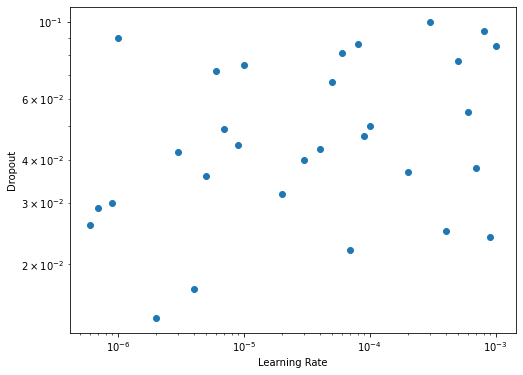

5e-05 0.067
0.0006 0.055
0.0001 0.05
4e-05 0.043
9e-06 0.044
7e-06 0.049
9e-05 0.047
0.0007 0.038
0.0002 0.037
5e-06 0.036
3e-06 0.042
3e-05 0.04
1e-06 0.09
9e-07 0.03
8e-05 0.086
0.0008 0.094
0.0003 0.1
2e-05 0.032
7e-07 0.029
6e-07 0.026
7e-05 0.022
0.0009 0.024
0.0004 0.025
1e-05 0.075
6e-06 0.072
6e-05 0.081
4e-06 0.017
2e-06 0.014
0.001 0.085
0.0005 0.077


In [90]:
n_hpsets = 30

def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

# lr_list = set()
# while len(lr_list) < n_hpsets:
#     lr_list.add(signif((np.random.uniform(1,9))*(10**-(np.random.uniform(3,6))),1))
# lr_list = list(lr_list)

# dropout_list = set()
# while len(dropout_list) < n_hpsets:
#     dropout_list.add(signif((np.random.uniform(1,9))*(10**-(np.random.uniform(1,3))),1))
# dropout_list = list(dropout_list)

lr_list = set()
while len(lr_list) < n_hpsets:
    lr_list.add(signif(np.random.uniform(1,100000)*10**-8,1))
lr_list = list(lr_list)

dropout_list = set()
while len(dropout_list) < n_hpsets:
    dropout_list.add(signif(np.random.uniform(1,100)*10**-3,2))
dropout_list = list(dropout_list)

fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,6))
ax.plot(lr_list, dropout_list, 'o')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Dropout')
plt.xlabel('Learning Rate')
plt.show()

for lr, do in zip(lr_list, dropout_list):
    print(lr,do)

In [91]:
hp_search_results = []

for learning_rate, dropout_rate in zip(lr_list, dropout_list):

    model_result = {}

    model_result['batch_size'] = batch_size
    model_result['train_size'] = stage1_n_train
    model_result['dev_size'] = stage1_n_dev

    ########## HPs

    # learning_rate = lr # sets AdamW optimizaiton learning rate
                        # scales scales with each training loop if scheduler is on
    model_result['learning_rate'] = learning_rate

    # dropout_rate = drop # sets same dropout for roberta and for classification layer
    model_result['dropout_rate'] = dropout_rate
    print(dropout_rate)

    normalizer_before_class = False # toggle the normalizer before the classification layer
    model_result['normalizer_before_class'] = normalizer_before_class

    use_lr_scheduler = False # toggle the linear learning rate scheduler
    model_result['use_lr_scheduler'] = use_lr_scheduler

    n_epochs = 8

    ########### For saving (not used)

    run_name = model_name.split('/')[-1] +'_bs-'+str(batch_size)+\
                                            '_lr-'+str(learning_rate)+\
                                            '_drop-'+str(dropout_rate)+\
                                            '_norm-'+str(normalizer_before_class)[0]+\
                                            '_sched-'+str(use_lr_scheduler)[0]
    runoutpath = os.path.join(outputpath,run_name+'/')


    ########### build/train/eval outer loop

    model = build_model(dropout_rate, normalizer_before_class)

    criterion = torch.nn.CrossEntropyLoss(reduction='sum')
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    num_total_steps = n_epochs * (len(batched_train_ds) * 2 + len(batched_dev_ds))
    progress_bar = tqdm(range(num_total_steps))

    n_training_steps = n_epochs * len(batched_train_ds)
    if use_lr_scheduler:
        n_training_steps = n_epochs * len(batched_train_ds)
        lr_scheduler = get_scheduler(
            name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=n_training_steps
        )

    run_report = train_dev_loop(n_epochs)

    ########## Tabulate results

    model_result['wt_f1'] = tabulate_metrics(run_report['eval_dev_rpt'])['wt_f1']
    model_result['train_loss'] = run_report['train_loss']
    model_result['eval_train_loss'] = run_report['eval_train_loss']
    model_result['eval_dev_loss'] = run_report['eval_dev_loss']

    hp_search_results.append(model_result)




0.067


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.2448051948051948
epoch 4		weighted dev eval f1 0.39190064805969377
epoch 5		weighted dev eval f1 0.3978317012578918
epoch 6		weighted dev eval f1 0.45007944659691873
epoch 7		weighted dev eval f1 0.5548821985082288
epoch 8		weighted dev eval f1 0.5452953743033147
0.055


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.0
epoch 8		weighted dev eval f1 0.0
0.05


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.2965225935764938
epoch 3		weighted dev eval f1 0.3838173394463417
epoch 4		weighted dev eval f1 0.552097816364443
epoch 5		weighted dev eval f1 0.5810228373911412
epoch 6		weighted dev eval f1 0.47187481844704715
epoch 7		weighted dev eval f1 0.5766599865725593
epoch 8		weighted dev eval f1 0.5927189740779086
0.043


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.26937083963836306
epoch 4		weighted dev eval f1 0.3809426823935225
epoch 5		weighted dev eval f1 0.389793167777577
epoch 6		weighted dev eval f1 0.4145399505827313
epoch 7		weighted dev eval f1 0.4151524077297273
epoch 8		weighted dev eval f1 0.4608758222470868
0.044


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.03401759530791789
epoch 8		weighted dev eval f1 0.19453325445856476
0.049


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.03756119526669835
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.005155300972791467
epoch 8		weighted dev eval f1 0.027315541601255888
0.047


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.28502288124929637
epoch 3		weighted dev eval f1 0.3820831168831169
epoch 4		weighted dev eval f1 0.36634446026752054
epoch 5		weighted dev eval f1 0.40352350048849617
epoch 6		weighted dev eval f1 0.48115492356991746
epoch 7		weighted dev eval f1 0.5749296300239282
epoch 8		weighted dev eval f1 0.5167997343513347
0.038


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.0
epoch 8		weighted dev eval f1 0.0
0.037


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.2417696426255628
epoch 5		weighted dev eval f1 0.26992216843719924
epoch 6		weighted dev eval f1 0.4570105082544372
epoch 7		weighted dev eval f1 0.3818155909454263
epoch 8		weighted dev eval f1 0.48740233513015424
0.036


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.013783179817632312
epoch 2		weighted dev eval f1 0.001913875598086124
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.0
epoch 8		weighted dev eval f1 0.0
0.042


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.036752296348989695
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.0
epoch 8		weighted dev eval f1 0.0
0.04


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.26342085043383745
epoch 5		weighted dev eval f1 0.29960857842930244
epoch 6		weighted dev eval f1 0.3971802751764472
epoch 7		weighted dev eval f1 0.48640585538784237
epoch 8		weighted dev eval f1 0.521302191041022
0.09


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.012220420289193679
epoch 2		weighted dev eval f1 0.01756572579833697
epoch 3		weighted dev eval f1 0.022804884302845163
epoch 4		weighted dev eval f1 0.01838739754837932
epoch 5		weighted dev eval f1 0.011392886392886393
epoch 6		weighted dev eval f1 0.009466237087720463
epoch 7		weighted dev eval f1 0.00674715909090909
epoch 8		weighted dev eval f1 0.0013557870700727844
0.03


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.03574183713123678
epoch 2		weighted dev eval f1 0.04105992589234333
epoch 3		weighted dev eval f1 0.033983826652912504
epoch 4		weighted dev eval f1 0.03562314589435332
epoch 5		weighted dev eval f1 0.025758067384290394
epoch 6		weighted dev eval f1 0.015376541455784504
epoch 7		weighted dev eval f1 0.00863347120511459
epoch 8		weighted dev eval f1 0.0022534543082488286
0.086


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.007645737720925692
epoch 3		weighted dev eval f1 0.28504237075665645
epoch 4		weighted dev eval f1 0.49373125775116317
epoch 5		weighted dev eval f1 0.48915945663531873
epoch 6		weighted dev eval f1 0.5112975834716631
epoch 7		weighted dev eval f1 0.5802260441316993
epoch 8		weighted dev eval f1 0.5725845381763122
0.094


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.0
epoch 8		weighted dev eval f1 0.0
0.1


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.0
epoch 8		weighted dev eval f1 0.0
0.032


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.05451820906366361
epoch 5		weighted dev eval f1 0.28773463885910144
epoch 6		weighted dev eval f1 0.33215567492111553
epoch 7		weighted dev eval f1 0.4236735426736606
epoch 8		weighted dev eval f1 0.5155490269013376
0.029


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.02261196114835045
epoch 2		weighted dev eval f1 0.018422394690893632
epoch 3		weighted dev eval f1 0.013143983484865382
epoch 4		weighted dev eval f1 0.011099828718783991
epoch 5		weighted dev eval f1 0.007704054574496967
epoch 6		weighted dev eval f1 0.004033295658911422
epoch 7		weighted dev eval f1 0.002574416733708769
epoch 8		weighted dev eval f1 0.0
0.026


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.025279219154625707
epoch 2		weighted dev eval f1 0.031192369195821436
epoch 3		weighted dev eval f1 0.031219670169624607
epoch 4		weighted dev eval f1 0.03265387371670899
epoch 5		weighted dev eval f1 0.028836319461979402
epoch 6		weighted dev eval f1 0.023152923631392534
epoch 7		weighted dev eval f1 0.014982068556387413
epoch 8		weighted dev eval f1 0.0070188691809543536
0.022


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.27295977940801014
epoch 3		weighted dev eval f1 0.4072486142901373
epoch 4		weighted dev eval f1 0.5514085723669272
epoch 5		weighted dev eval f1 0.5820867201924884
epoch 6		weighted dev eval f1 0.5824354202402441
epoch 7		weighted dev eval f1 0.5290009695431884
epoch 8		weighted dev eval f1 0.5543130835708029
0.024


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.0
epoch 8		weighted dev eval f1 0.0
0.025


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.0
epoch 8		weighted dev eval f1 0.0
0.075


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0025776504863957335
epoch 6		weighted dev eval f1 0.03684359119141728
epoch 7		weighted dev eval f1 0.15644355644355643
epoch 8		weighted dev eval f1 0.25134822804314333
0.072


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.019268400979036846
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.0
epoch 8		weighted dev eval f1 0.0
0.081


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.020012459864858386
epoch 3		weighted dev eval f1 0.2653624436787702
epoch 4		weighted dev eval f1 0.393631488848808
epoch 5		weighted dev eval f1 0.5506162230824108
epoch 6		weighted dev eval f1 0.5721014533336435
epoch 7		weighted dev eval f1 0.5665279709489358
epoch 8		weighted dev eval f1 0.6095113790805508
0.017


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.03580843124479003
epoch 2		weighted dev eval f1 0.005116393040921343
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.0
epoch 8		weighted dev eval f1 0.0
0.014


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.02663880718172538
epoch 2		weighted dev eval f1 0.024508650978528425
epoch 3		weighted dev eval f1 0.031562843234548284
epoch 4		weighted dev eval f1 0.03785015372749566
epoch 5		weighted dev eval f1 0.01161714086169912
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.0
epoch 8		weighted dev eval f1 0.0
0.085


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.0
epoch 8		weighted dev eval f1 0.0
0.077


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/184 [00:00<?, ?it/s]

epoch 1		weighted dev eval f1 0.0
epoch 2		weighted dev eval f1 0.0
epoch 3		weighted dev eval f1 0.0
epoch 4		weighted dev eval f1 0.0
epoch 5		weighted dev eval f1 0.0
epoch 6		weighted dev eval f1 0.0
epoch 7		weighted dev eval f1 0.0
epoch 8		weighted dev eval f1 0.0


In [92]:
hptuningpath = os.path.join(outputpath,'hyperparam_tuning/')
try: os.makedirs(hptuningpath)
except: pass
hptuningpath

'/home/sam/MeasEval/baselines/../data/output/hyperparam_tuning/'

In [93]:
with open(hptuningpath+'hptuninng_train_docs.json','w') as f:
    json.dump(train_docs_small, f)
with open(hptuningpath+'hptuninng_dev_docs.json','w') as f:
    json.dump(dev_docs_small, f)

In [94]:
stage1_n_train

74

In [95]:
stage1_n_dev

19

In [96]:
hp_search_results_df = pd.DataFrame.from_dict(hp_search_results)


In [97]:
hp_search_results_df.to_csv(hptuningpath+'hp_search_results.csv')

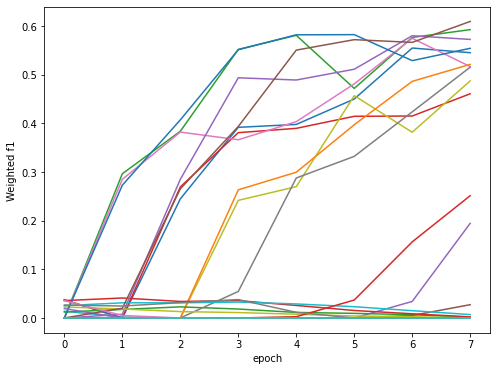

In [98]:
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,6))

for hpsetnum, hpset in hp_search_results_df.iterrows():
    label = str(hpsetnum)
    epoch = list(range(len(hpset['wt_f1'])))
    wt_f1 = hpset['wt_f1']
    ax.plot(epoch, wt_f1, label=label)

# plt.legend()
plt.xlabel('epoch')
plt.ylabel('Weighted f1')
plt.show()

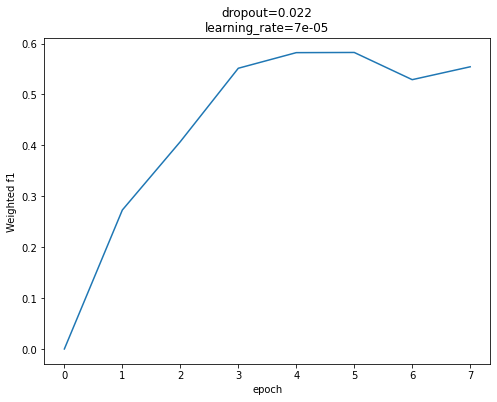

: 

In [99]:
besthps = np.argsort(hp_search_results_df['wt_f1'].apply(np.sum).values)[-1]
hpset = hp_search_results_df.loc[besthps]

best_lr = hpset['learning_rate']
best_dropout = hpset['dropout_rate']

epoch = list(range(len(hpset['wt_f1'])))
wt_f1 = hpset['wt_f1']
fig,ax=plt.subplots(nrows=1,ncols=1,figsize=(8,6))
ax.plot(epoch, wt_f1)

plt.title('dropout='+str(best_dropout)+'\nlearning_rate='+str(best_lr))
plt.xlabel('epoch')
plt.ylabel('Weighted f1')
plt.show()

In [71]:
len(train_docs_small)

74

In [62]:
hp_search_results_df.loc[besthps]

batch_size                                                                 8
train_size                                                                74
dev_size                                                                  19
learning_rate                                                        0.00009
dropout_rate                                                          0.0097
normalizer_before_class                                                False
use_lr_scheduler                                                       False
wt_f1                      0    0.000000
1    0.270184
2    0.379825
3   ...
train_loss                 [7151.13818359375, 3668.13623046875, 1962.1772...
eval_train_loss            [864.4190673828125, 886.8427124023438, 1477.69...
eval_dev_loss              [1267.427734375, 882.899658203125, 459.8088989...
Name: 6, dtype: object

In [63]:
besthps_df = pd.DataFrame.from_dict(hp_search_results).append(hp_search_results_df.loc[besthps])


/tmp/ipykernel_8693/3880526453.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  besthps_df = pd.DataFrame.from_dict(hp_search_results).append(hp_search_results_df.loc[besthps])
